# Lectura y preprocesamiento del dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import SimpleITK as sitk
import skimage
import os

from lukinoising4GP import lukinoising

In [2]:
metadata_path = 'dataset/ObjectDetection.xlsx'
df_metadata = pd.read_excel(metadata_path)
# Convert h_min, w_min, h_max, w_max to integers
for col in ['h_min', 'w_min', 'h_max', 'w_max']:
    df_metadata[col] = df_metadata[col].astype(int)
df_metadata.head(10)

,fname,structure,h_min,w_min,h_max,w_max
0,168.png,thalami,178,171,244,261
1,168.png,nasal bone,96,308,111,349
2,168.png,palate,133,300,205,408
3,168.png,nasal skin,86,324,95,349
4,168.png,nasal tip,79,345,89,376
5,168.png,midbrain,247,173,328,231
6,168.png,NT,385,257,418,464
7,168.png,IT,301,213,328,290
8,168.png,CM,345,216,367,304
9,169.png,nasal tip,80,240,86,264


In [3]:
# Keep only the rows where structure is NT
df_nt = df_metadata[df_metadata['structure'] == 'NT']
df_nt = df_nt.drop(columns=['structure'])
print(df_nt.shape)
df_nt.head(10)

(1110, 5)


,fname,h_min,w_min,h_max,w_max
6,168.png,385,257,418,464
16,169.png,372,126,428,371
20,170.png,376,12,416,478
30,171.png,359,173,389,529
37,172.png,375,293,399,380
43,173.png,377,345,396,542
53,9.png,389,239,411,374
59,832.png,377,90,415,347
62,833.png,358,223,405,389
73,834.png,344,203,373,321


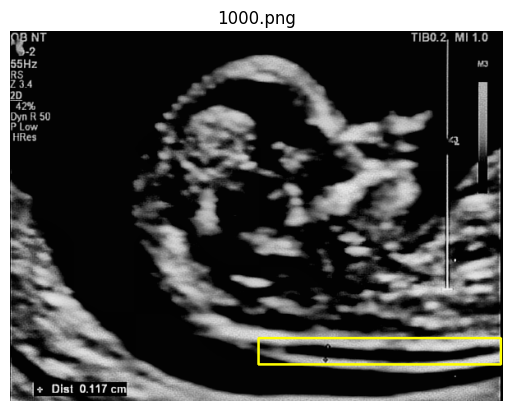

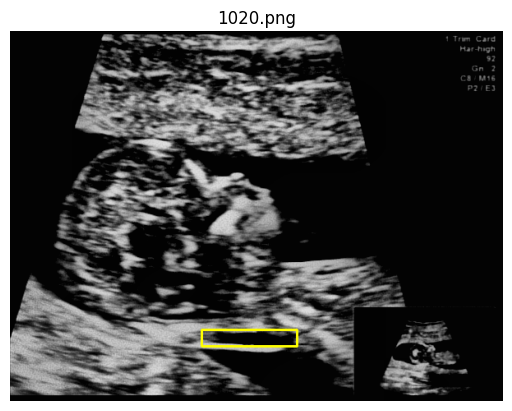

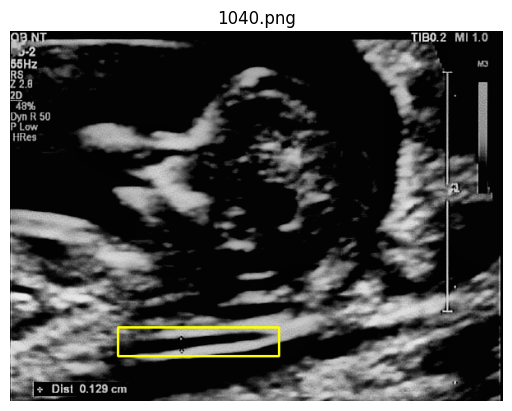

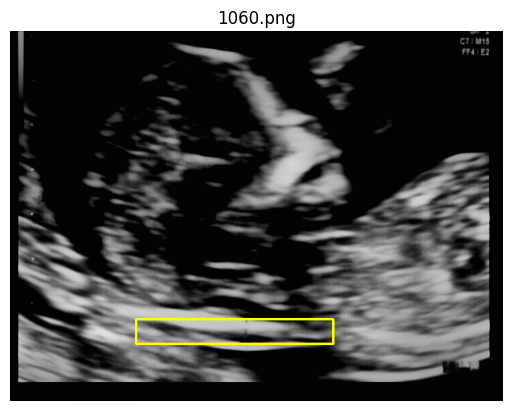

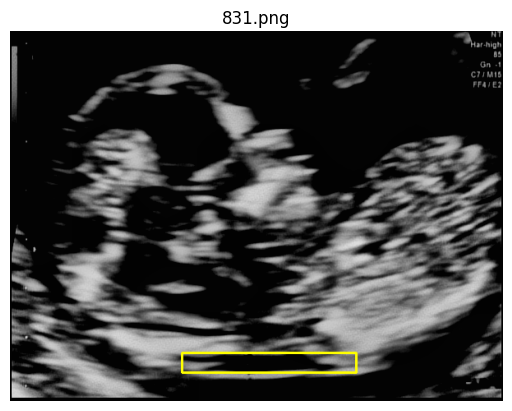

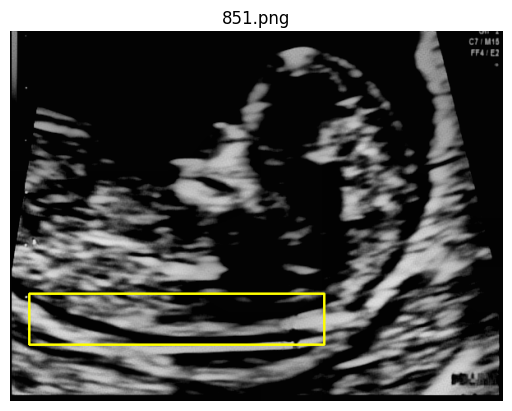

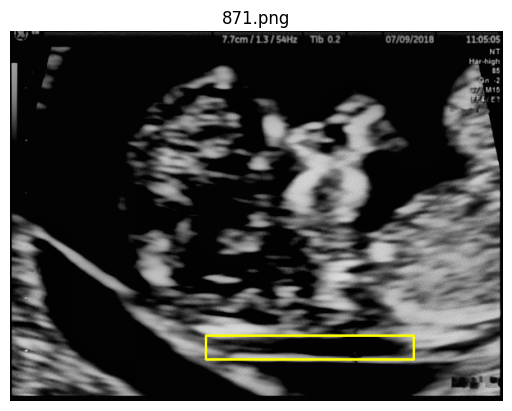

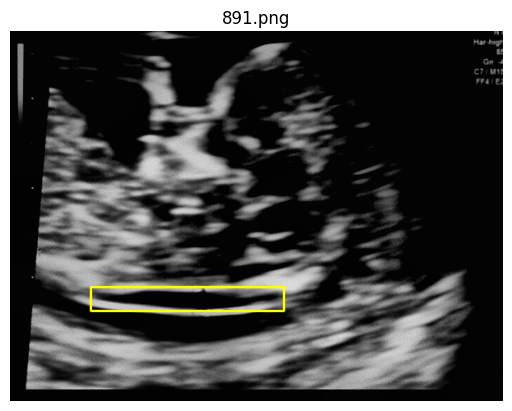

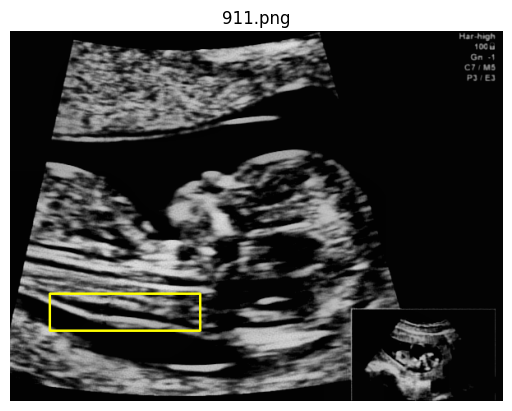

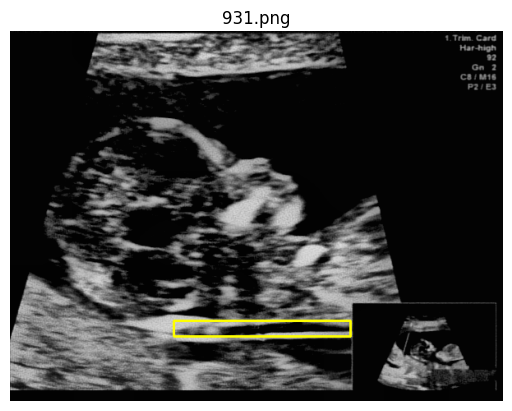

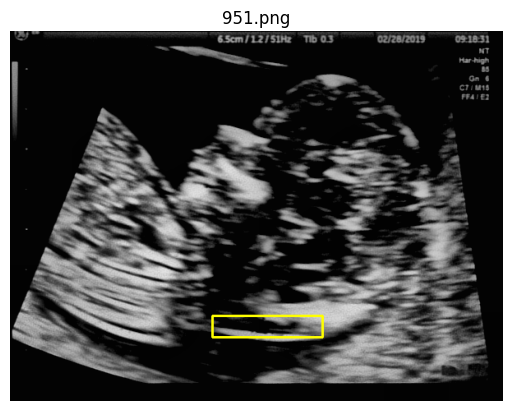

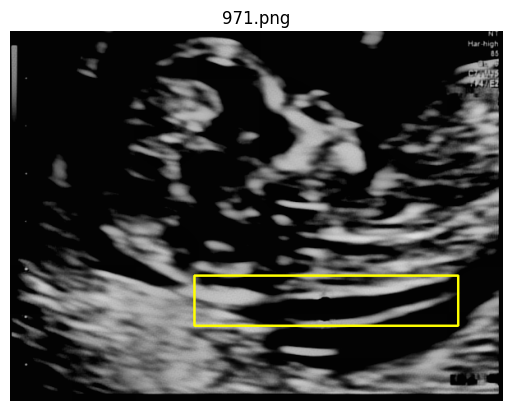

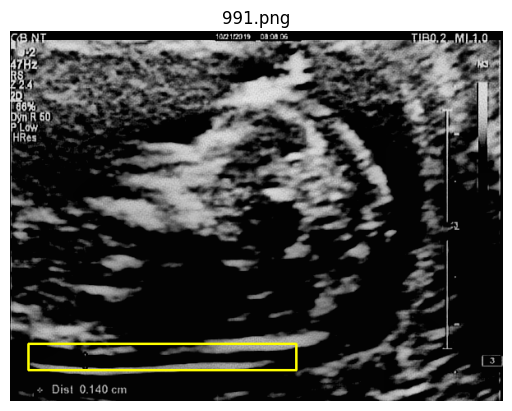

In [4]:
# Gather the images paths
dataset_path = 'dataset/Set2-Training&Validation Sets ANN Scoring system'
dataset_standard_path = os.path.join(dataset_path, 'Standard')
dataset_non_standard_path = os.path.join(dataset_path, 'Non-Standard')

valid_ids = df_nt['fname'].unique()
resize_dim = (600, 450)
images = []
image_ids = []
bounding_boxes = []

for i, fname in enumerate(os.listdir(dataset_standard_path)):
    if not fname.endswith('.png') or fname not in valid_ids:
        continue
    
    image_ids.append(fname)
    img_raw = cv2.imread(os.path.join(dataset_standard_path, fname), cv2.IMREAD_GRAYSCALE)

    # Resize image
    img = cv2.resize(img_raw, resize_dim)
    
    # Denoising

    img = lukinoising(img)

    # Equalize histogram to improve contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    
    # Convert to RGB for VGC16
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    images.append(img)
    
    # Get the bounding box coordinates
    h_min = df_nt[df_nt['fname'] == fname]['h_min'].values[0]
    h_max = df_nt[df_nt['fname'] == fname]['h_max'].values[0]
    w_min = df_nt[df_nt['fname'] == fname]['w_min'].values[0]
    w_max = df_nt[df_nt['fname'] == fname]['w_max'].values[0]
    
    # Resize the bounding box
    h_min = int(h_min * img.shape[0] / img_raw.shape[0])
    h_max = int(h_max * img.shape[0] / img_raw.shape[0])
    w_min = int(w_min * img.shape[1] / img_raw.shape[1])
    w_max = int(w_max * img.shape[1] / img_raw.shape[1])
    
    bounding_boxes.append(np.array([h_min, w_min, h_max, w_max]))
    
    # Draw the bounding box
    if not i%20:
        img_rect = cv2.rectangle(img.copy(), (w_min, h_min), (w_max, h_max), (255, 255, 0), 2)
       
        plt.imshow(img_rect, cmap='gray')
        plt.axis('off')
        plt.title(fname)
        plt.show()  

images = np.array(images)
bounding_boxes = np.array(bounding_boxes)

# VGG16 Neural net for bounding box regression

In [5]:
#import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split

In [6]:
images.shape

(244, 450, 600, 3)

In [7]:
images.shape[1:3]*2

(450, 600, 450, 600)

In [8]:
normalized = False

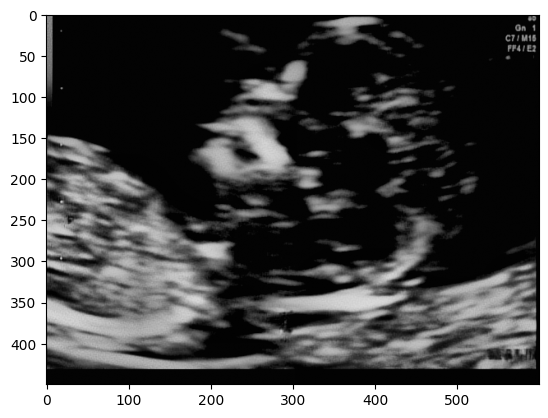

In [32]:
if not normalized:
    # Normalize images and bounding boxes
    images = images / 255.0
    bounding_boxes = bounding_boxes / np.array(images.shape[1:3] * 2)
    normalized = True

# Split the dataset
train_x, val_x, train_y, val_y = train_test_split(images, bounding_boxes, test_size=0.2)

plt.imshow(train_x[0], cmap='gray')
plt.show()

In [33]:
# Define the model
def create_model(input_shape):
    vgg16 = VGG16(include_top=False, input_shape=input_shape)
    vgg16.trainable = False
    
    model = Sequential()
    model.add(vgg16)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    
    return model

model = create_model(images[0].shape)

model.summary()
    

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 14, 18, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 129024)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    16,515,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,238,404 (119.17 MB)

 Trainable params: 16,523,716 (63.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
# Train the model
lr = 1e-4
checkpoint = ModelCheckpoint('model2.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(optimizer=Adam(learning_rate=lr), loss=MeanSquaredError(), metrics=[MeanSquaredError()])
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=32, epochs=30, callbacks=[checkpoint,rlrop,early_stopping])


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 0.0967 - mean_squared_error: 0.0954 - val_loss: 0.0219 - val_mean_squared_error: 0.0213 - learning_rate: 1.0000e-04
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 0.0172 - mean_squared_error: 0.0171 - val_loss: 0.0120 - val_mean_squared_error: 0.0123 - learning_rate: 1.0000e-04
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 0.0082 - mean_squared_error: 0.0083 - val_loss: 0.0098 - val_mean_squared_error: 0.0096 - learning_rate: 1.0000e-04
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0086 - val_mean_squared_error: 0.0089 - learning_rate: 1.0000e-04
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - loss: 0.0042 - mean_squared_error: 0.0041 - val_loss: 0.0081 - val_mean_squared_error: 0.0084 - learning_rate: 1.0000e-04
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 0.0037 - mean_squared_error: 0.0036 - val_loss: 0.0066 - val_mean_squared_error: 0.0

In [35]:
def compare_segmentations(model: Model, img: np.ndarray, bounding_box: np.ndarray) -> float:
    """
    Side by side plot comparing original bounding box and the predicted one,
    by resizing the model output to original image size and superimposing
    :param model: regression model
    :param img: original image 
    :param bounding_box: origina bounding box
    :return: mean squared error 
    """
    bounding_box = bounding_box.copy()
    img = img.copy()

    rescaling_arr = np.array(img.shape[:2] * 2)
    
    pred = model.predict(np.array([img]))[0]
    pred *= rescaling_arr
    bounding_box *= rescaling_arr

    mse = np.mean((bounding_box - pred) ** 2)

    bounding_box = np.int32(bounding_box)
    pred = np.int32(pred)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    img_with_bb = cv2.rectangle(img.copy(), (int(bounding_box[1]), int(bounding_box[0])), (int(bounding_box[3]), int(bounding_box[2])), (255, 255, 0), 2)
    img_with_pred_bb = cv2.rectangle(img.copy(), (int(pred[1]), int(pred[0])), (int(pred[3]), int(pred[2])), (0, 255, 0), 2)
    axs[0].imshow(img_with_bb)
    axs[0].axis('off')
    axs[0].set_title('Original bounding box')
    axs[1].imshow(img_with_pred_bb)
    axs[1].axis('off')
    axs[1].set_title('Predicted bounding box')
    plt.show()
    
    return mse
    

In [36]:
img = val_x[0]
np.array(img.shape[:2] * 2)

array([450, 600, 450, 600])

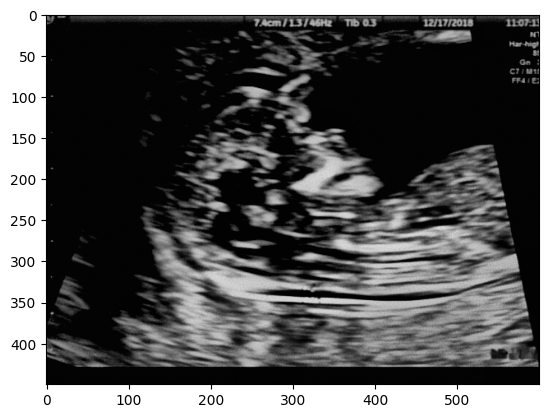

(450, 600, 3)
(450, 600, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
[[0.75771105 0.47481087 0.8605158  0.8373653 ]]


In [37]:
plt.imshow(val_x[0], cmap='gray')
plt.show()
print(val_x[0].shape)
print(images[0].shape)

print(model.predict(np.array([val_x[0]])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


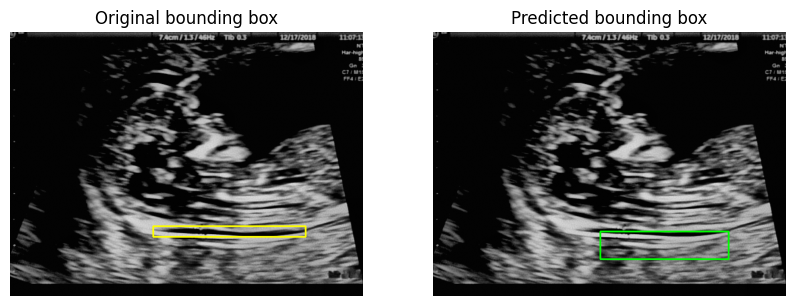

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


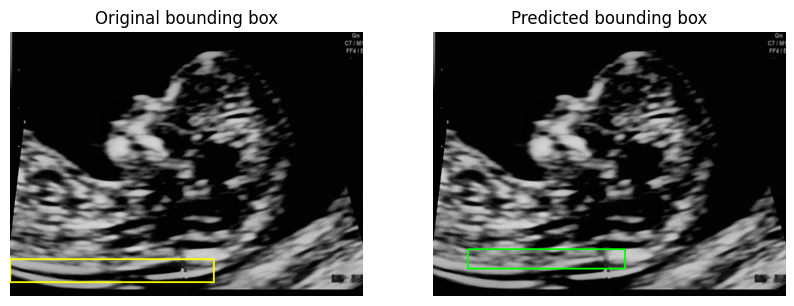

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


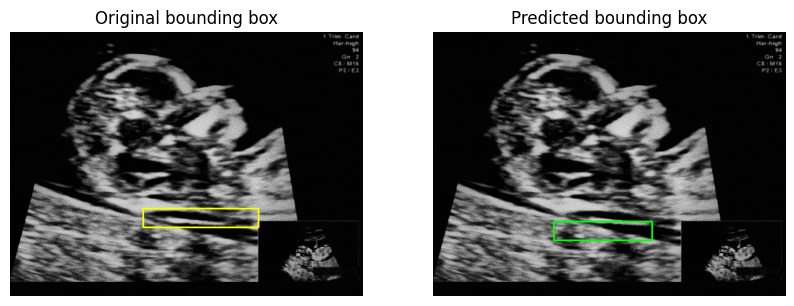

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


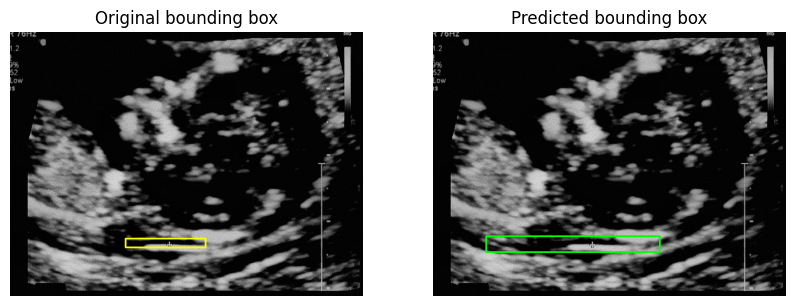

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


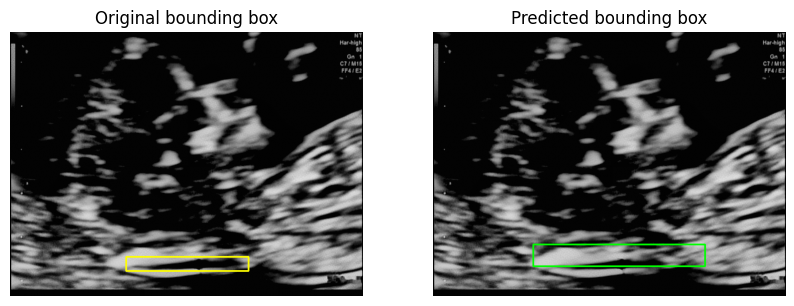

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


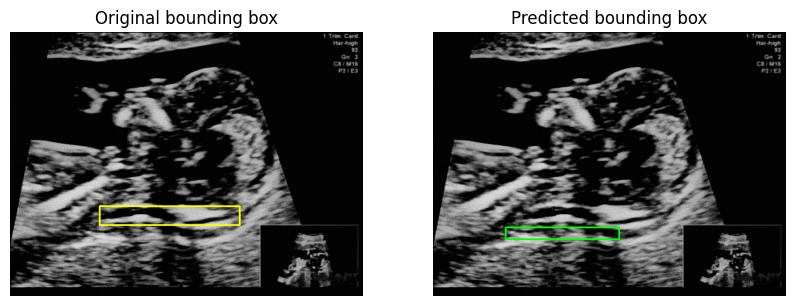

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


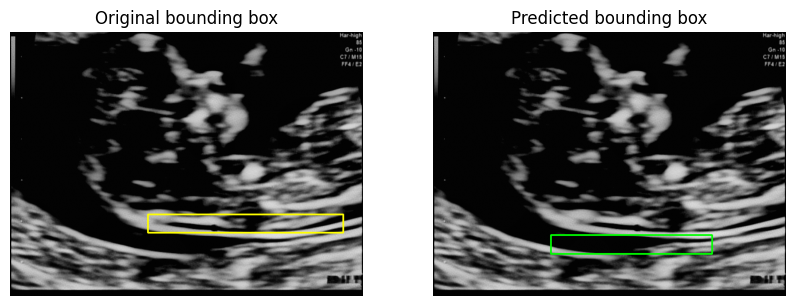

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


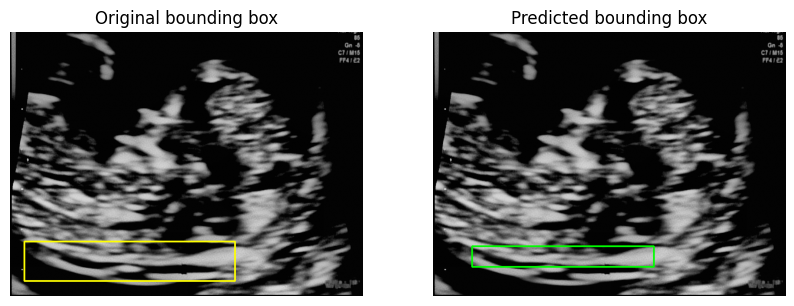

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


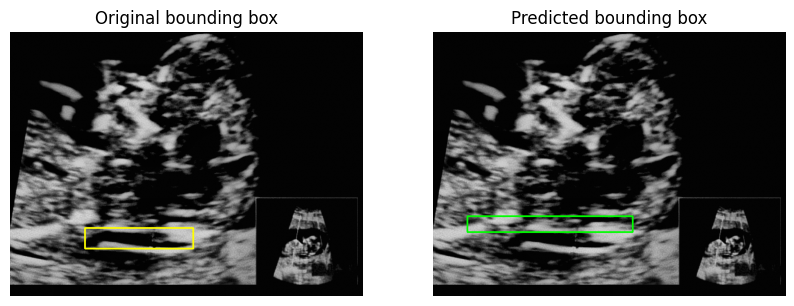

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


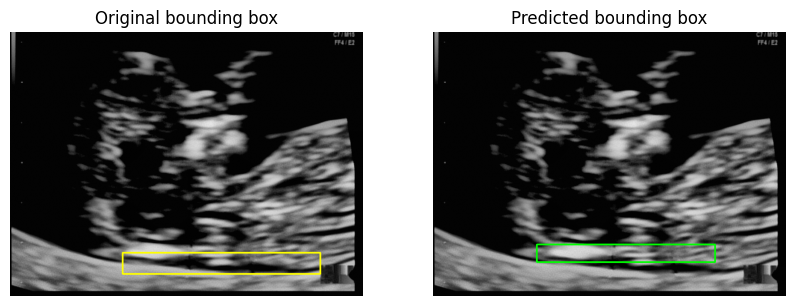

In [38]:
# Compare segmentation
for i in range(0,10):
    compare_segmentations(model, val_x[i], val_y[i])